# Scam Detection Algorithm using Naive-Bayes Classification Model

## Imports and Data Visualization

In [1]:
### import Dependencies and Dataset

import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Marusenka\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
### import dataset and replace the null values with a null string

dataset = pd.read_csv('SpamCollection(NB).csv')
data = dataset.where((pd.notnull(dataset)), '')
data = data.drop(data[(data.Category != 0.0) & (data.Category != 1.0)].index)

In [3]:
### inspect and visualize data

data.head()

,Message,Category
0,date wed NUMBER aug NUMBER NUMBER NUMBER NUMB...,0.0
1,martin a posted tassos papadopoulos the greek ...,0.0
2,man threatens explosion in moscow thursday aug...,0.0
3,klez the virus that won t die already the most...,0.0
4,in adding cream to spaghetti carbonara which ...,0.0


In [4]:
data.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
0.0         2500   2445                     url URL date not supplied URL    
1.0          500    427  lowest rates available for term life insurance...   

               
         freq  
Category       
0.0        10  
1.0         5

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 0 to 3015
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Message   3000 non-null   object
 1   Category  3000 non-null   object
dtypes: object(2)
memory usage: 70.3+ KB


In [6]:
data.shape

(3000, 2)

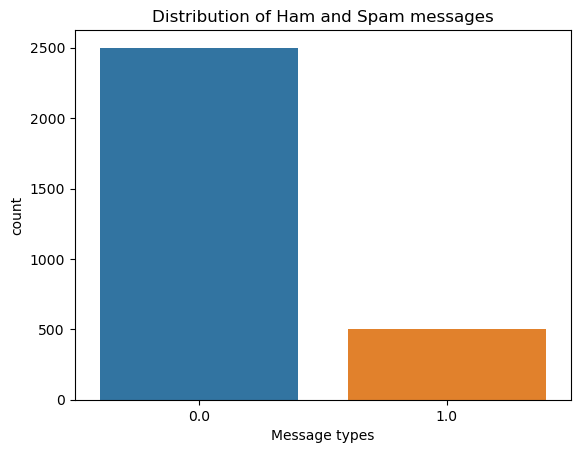

In [7]:
sns.countplot(x='Category', data=data)
plt.title('Distribution of Ham and Spam messages')
plt.xlabel('Message types')
plt.show()

C:\Users\Marusenka\AppData\Local\Temp\ipykernel_24892\2212697028.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = ham_msg.append(spam_msg)\


Text(0.5, 0, 'Message types')

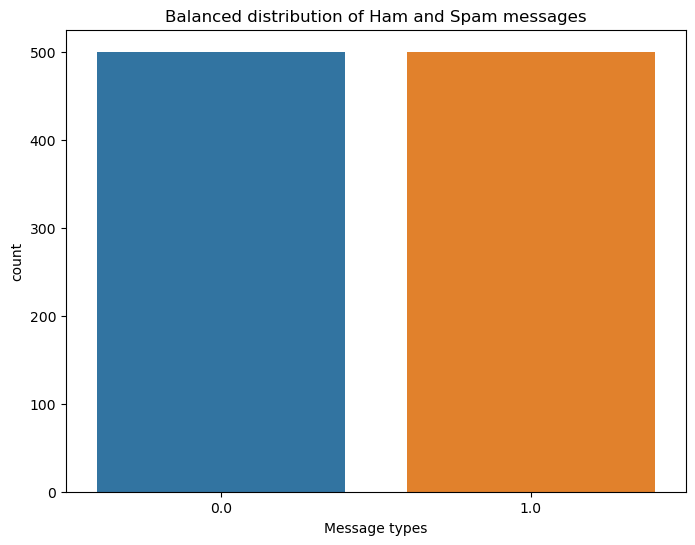

In [8]:
# downsample to balance the dataset

ham_msg = data[data.Category == 0.0]
spam_msg = data[data.Category == 1.0]
ham_msg = ham_msg.sample(n=len(spam_msg),
                         random_state=42)

data = ham_msg.append(spam_msg)\
    .reset_index(drop=True)

plt.figure(figsize=(8, 6))
sns.countplot(data = data, x='Category')
plt.title('Balanced distribution of Ham and Spam messages')
plt.xlabel('Message types')

In [9]:
data.shape

(1000, 2)

In [10]:
data.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
0.0          500    496  url URL date NUMBER NUMBER NUMBERtNUMBER NUMBE...   
1.0          500    427  lowest rates available for term life insurance...   

               
         freq  
Category       
0.0         2  
1.0         5

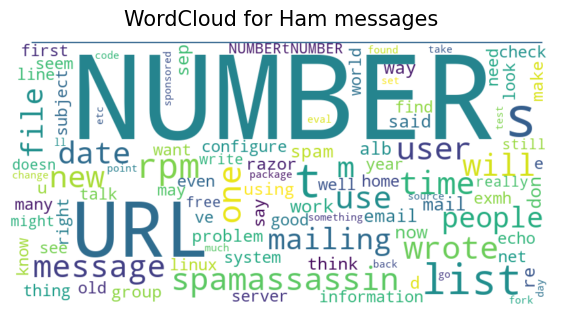

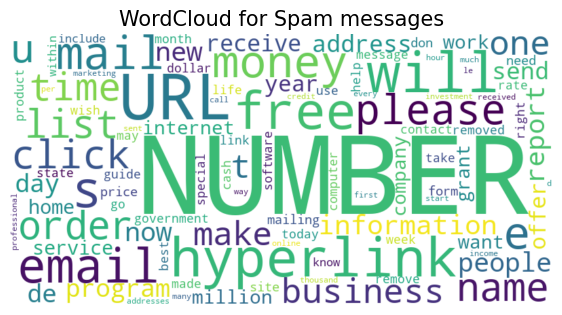

In [11]:
## visualize frequency of words

def plot_word_cloud(data, typ):
    message = " ".join(data['Message'])
    plt.figure(figsize=(7, 7))
    wc = WordCloud(background_color='white',
                   max_words=100,
                   width=800,
                   height=400,
                   collocations=False).generate(message)
    plt.imshow(wc, interpolation='bilinear')
    plt.title(f'WordCloud for {typ} messages', fontsize=15)
    plt.axis('off')
    plt.show()
    
plot_word_cloud(data[data['Category'] == 0.0], typ='Ham')
plot_word_cloud(data[data['Category'] == 1.0], typ='Spam')

## Data Preparation

In [12]:
### remove punctuation from the dataset and transform all letters to lowercase

punctuation_list = string.punctuation
def remove_punctuation(text):
    remove_punct = "".join([word.lower() for word in text if word not in punctuation_list])
    return remove_punct
 
data['Message']= data['Message'].apply(lambda x: remove_punctuation(x))
data.head()

,Message,Category
0,on fri sep number number at number number numb...,0.0
1,have you thought of bumping up sylpheed claws ...,0.0
2,title page has a login screen and i can t seem...,0.0
3,url url date not supplied img url wonderful ga...,0.0
4,url spamassassin contrib url changed what rem...,0.0


In [13]:
### remove stopwords (common words) from the dataset

def remove_stopwords(text):
    stop_words = stopwords.words('english')
    ok_words = []
    for word in str(text).split():
        if word not in stop_words:
            ok_words.append(word)
    output = " ".join(ok_words)
    return output
 
data['Message'] = data['Message'].apply(lambda text: remove_stopwords(text))
data.head()

,Message,Category
0,fri sep number number number number numberam n...,0.0
1,thought bumping sylpheed claws see sylpheed go...,0.0
2,title page login screen seem get apt indexes a...,0.0
3,url url date supplied img url wonderful galler...,0.0
4,url spamassassin contrib url changed removed a...,0.0


In [14]:
### transform spam and ham categories into numerical data

data.loc[data['Category'] == 0.0, 'Category', ] = 0
data.loc[data['Category'] == 1.0, 'Category', ] = 1

In [15]:
### create train and test data (80%-20%)

X = data['Message']
Y = data['Category']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

In [16]:
### store data (wordcount) as a matrix (for X) and convert to integers (for Y)

cv = CountVectorizer()

X_train_count = cv.fit_transform(X_train.values)
X_test_count = cv.transform(X_test)

Y_train = Y_train.astype('int')
Y_test = Y_test.astype('int')

## Model Building

In [17]:
### fit model against training data with Naive-Bayes model

model = MultinomialNB()
model.fit(X_train_count, Y_train)

print('Accuracy score on train data is: ', model.score(X_train_count, Y_train))

Accuracy score on train data is:  0.9925


In [18]:
### pre-test ham message

message_ham = ['Hey wanna hang out later this afternoon?']
message_ham_count = cv.transform(message_ham)
if model.predict(message_ham_count) == [0]:
    print('Message is not a scam')
else:
    print('Message is a scam')

Message is not a scam


In [19]:
#pre-test spam message

message_spam = ['Invest today on http:/invest.com']
message_spam_count = cv.transform(message_spam)
if model.predict(message_spam_count) == [0]:
    print('Message is not a scam')
else:
    print('Message is a scam')

Message is a scam


In [20]:
### test trained model against testing data

print('Accuracy score on test data is: ', model.score(X_test_count, Y_test))

Accuracy score on test data is:  0.98


In [21]:
## export fitted vocabulary

x_data = cv.fit(X_train.values)
pickle.dump(x_data, open("NBvectorizer.pkl", "wb"))

In [22]:
## export model

pickle.dump(model, open("NB_scam_detection_model.pkl", "wb"))